In [1]:
import matplotlib
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import sys
basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))
from utils.plot_utils import *

100%|██████████| 6/6 [00:00<00:00, 556.14it/s]


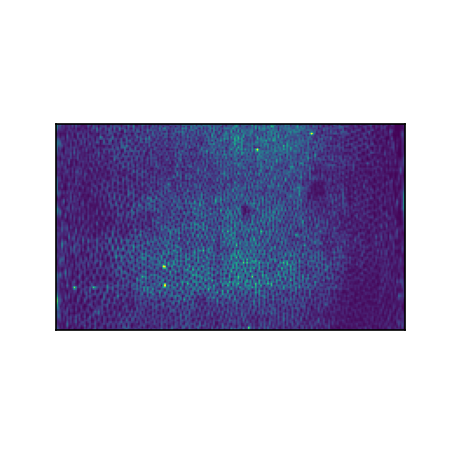

In [2]:
%matplotlib widget

plt.rcParams['font.size'] = 6
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

from utils.dataset import *

transform = Reshape2DField()

datasets = {
    #'cad': AtlasDataset('WT', 'ECad-GFP', 'tensor2D', transform=transform),
    'cad_cyt': AtlasDataset('WT', 'ECad-GFP', 'cyt2D', transform=transform),
    'cad_raw': AtlasDataset('WT', 'ECad-GFP', 'raw2D', transform=transform),
    'cvel': AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform),
    'svel': AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, drop_time=True),

    'sqh_cyt': AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'cyt2D', transform=transform, drop_time=True),
    'sqh_raw': AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'raw2D', transform=transform, drop_time=True),
    'sqh_ten': AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform, drop_time=True),

    #'runt': AtlasDataset('WT', 'Runt', 'raw2D', transform=transform)
}

'''
Set up plots
'''
import ipywidgets as ipw

output = ipw.Output()
with output:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
    
dataset_select = ipw.Dropdown(
    options=datasets,
    description='Dataset',
)

df = dataset_select.value.df
embryo_select = ipw.Dropdown(
    options=df.embryoID.unique(),
    description='Embryo',
    continuous_update=False,
)

ekey = embryo_select.value
time_select = ipw.FloatSlider(
    min=df.loc[df.embryoID==ekey, 'time'].min(),
    max=df.loc[df.embryoID==ekey, 'time'].max(),
    description='Time',
)

def update_embryo(_):
    df = dataset_select.value.df
    options = df.embryoID.unique()
    embryo_select.options = options
    embryo_select.value = options[0]
    update_time(None)
    
def update_time(_):
    global vmin, vmax
    df = dataset_select.value.df
    ekey = embryo_select.value
    
    data = dataset_select.value.values[ekey]
    data = data.reshape([data.shape[0], -1, *data.shape[-2:]])
    data = np.linalg.norm(data, axis=1)
    vmin = np.min(data)
    vmax = vmin + 7 * np.std(data)
    #vmax = np.max(data)
    
    time_select.min = df.loc[df.embryoID==ekey, 'time'].min()
    time_select.max = df.loc[df.embryoID==ekey, 'time'].max()
    time_select.value = time_select.min
    update_plot(None)

def update_plot(_):
    dataset = dataset_select.value
    ekey = embryo_select.value
    time = time_select.value
    
    df = dataset.df[dataset.df.embryoID == ekey]
    row = (df['time']-time).abs().argmin()
    idx = df.iloc[row].name
    data = dataset[idx]['value']
    
    ax.clear()
    if data.shape[0] == 1:
        color_2D(ax, data, vmin=vmin, vmax=vmax, cmap='viridis')
    elif data.shape[0] == 2:
        plot_vector2D(ax, data)#, vmin=vmin, vmax=vmax)
    elif data.shape[0] == 4:
        plot_tensor2D(ax, data, vmin=vmin, vmax=vmax)
    
dataset_select.observe(update_embryo, names=['value'])
embryo_select.observe(update_time, names=['value'])
time_select.observe(update_plot, names=['value'])
update_embryo(None)

control = ipw.VBox([
    dataset_select,
    embryo_select,
    time_select
])
display(ipw.VBox([control, output]))

In [6]:
ds = datasets['sqh_cyt']
df = ds.df
df.groupby('embryoID').agg('min').reset_index()

,embryoID,folder,tiff,time,eIdx
0,202006261115,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,1,0
1,202007011145,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,-15,6
2,202007081130,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,-13,0
3,202007091200,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,-15,6
4,202008131005,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,-10,0
5,202009041145,/project/vitelli/jonathan/REDO_fruitfly/flydri...,MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif,-11,0


<HDF5 file "symmetric_dynamics_fitting.h5" (mode r)>


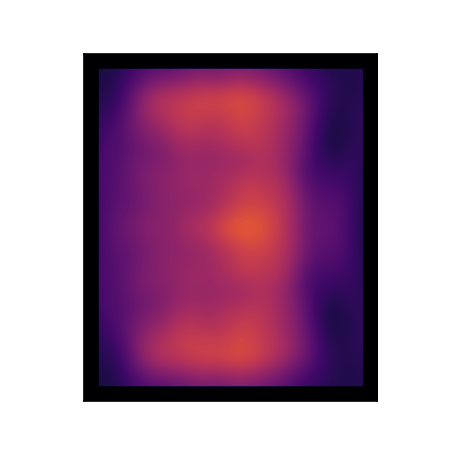

In [12]:
%matplotlib widget

plt.rcParams['font.size'] = 6
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

'''
Set up plots
'''
import ipywidgets as ipw

output = ipw.Output()
with output:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

if 'embs' in locals() or 'embs' in globals():
    embs.close()
    ens.close()
import h5py
dyn = h5py.File('data/symmetric_dynamics_fitting.h5', 'r')

    
datasets = {
    'tensor dynamics': dyn,
}
dataset_select = ipw.Dropdown(
    options=datasets,
    description='Dataset',
)

dataset = dataset_select.value
print(dataset)
embryo_select = ipw.Dropdown(
    options=list(dataset.keys()),
    description='Embryo',
    continuous_update=False,
)

embryo = dataset[embryo_select.value]
time_select = ipw.FloatSlider(
    min=np.min(embryo['t']),
    max=np.max(embryo['t']),
    description='Time',
)

field_select = ipw.Dropdown(
    options=list(embryo['fields'].keys()),
    description='Field',
    continuous_update=False
)


def update_embryo(_):
    dataset = dataset_select.value
    options = list(dataset.keys())
    embryo_select.options = options
    embryo_select.value = options[0]
    update_data(None)

def update_data(_):
    global vmin, vmax
    dataset = dataset_select.value
    embryo = dataset[embryo_select.value]

    options=list(embryo['fields'].keys())
    field_select.options = options
    
    data = embryo['fields'][field_select.value]
    if len(data.shape) == 5:
        normed=np.linalg.norm(data, axis=(1, 2))
    elif len(data.shape) == 4:
        normed=np.linalg.norm(data, axis=1)
    else:
        normed = data

    vmin = np.min(normed)
    vmax = np.max(normed)

    if field_select.value in embryo['X_cpt'].keys() or field_select.value == 'v':
        time = embryo['t']
    else:
        time = embryo['U_cpt'].attrs['t']
    time_select.min = np.min(time)
    time_select.max = np.max(time)

    time_select.value = np.clip(time_select.value, time_select.min, time_select.max)
    update_plot(None)

def update_plot(_):
    dataset = dataset_select.value
    embryo = dataset[embryo_select.value]
    time = time_select.value
    data = embryo['fields'][field_select.value]

    if field_select.value in embryo['X_cpt'].keys() or field_select.value == 'v':
        idx = np.argmin(np.abs(embryo['t'][:] - time))
    else:
        idx = np.argmin(np.abs(embryo['U_cpt'].attrs['t'] - time))
    data = data[idx][()].reshape([-1, *data.shape[-2:]])

    ax.clear()
    if data.shape[0] == 1:
        color_2D(ax, data, vmin=vmin, vmax=vmax)
    elif data.shape[0] == 2:
        plot_vector2D(ax, data)
    elif data.shape[0] == 4:
        plot_tensor2D(ax, data)

dataset_select.observe(update_embryo, names=['value'])
embryo_select.observe(update_data, names=['value'])
time_select.observe(update_plot, names=['value'])
field_select.observe(update_data, names=['value'])
update_embryo(None)

control = ipw.VBox([
    dataset_select,
    embryo_select,
    field_select,
    time_select
])
display(ipw.VBox([control, output]))